# Notebook 1 IA-024-2024S2 FEEC-UNICAMP - Lucas Couto Lima RA: 220696

## Instalação e importação de pacotes

In [ ]:
!pip install datasets portalocker>=2.0.0 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cufft-cu12==11.0.2.54; platform_system == "Linux" and platform_machi

In [ ]:
import torch
import random
from torch.utils.data import Dataset, DataLoader

from collections import Counter
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset

## I - Vocabulário e Tokenização

### Exemplo do dataset

In [ ]:
train_dataset = load_dataset("stanfordnlp/imdb", split="train")
test_dataset = load_dataset("stanfordnlp/imdb", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
len(train_dataset)

25000

# Exercício I.1:

In [ ]:
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

counter = Counter()
counter_label = Counter({0: 0, 1: 0}) # Adição: Contador para o número de amostras positivas e amostras negativas
total_text_length = 0 # Adição: Varíavel para calcular o comprimento total de textos do dataset
for sample in train_dataset: #
    counter.update(sample["text"].split())
    label = sample["label"] # Adição: Identifica se a amostra é positiva ou negativa
    counter_label[label] += 1 # Adição: Atualiza o contador de acordo com o rótulo

    total_text_length += len(sample["text"].split()) # Adição: Atualiza o comprimento total do texto

# Calcula o comprimento médio do texto
total_size = counter_label[1]+counter_label[0] # Adição: Cálcula o número total de amostras
average_text_length = total_text_length / total_size # Adição: Calcula o comprimento médio do texto

# Adição: Exibição dos resultados
print(f"Número de amostras positivas: {counter_label[1]}")
print(f"Número de amostras negativas: {counter_label[0]}")
print(f"Número total de amostras: {total_size}")
print(f"Comprimento médio do texto (em número de palavras): {average_text_length}")

Número de amostras positivas: 12500
Número de amostras negativas: 12500
Número total de amostras: 25000
Comprimento médio do texto (em número de palavras): 233.7872


# Exercício I.2:

In [ ]:
# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}
vocab_size = len(vocab)

print(f"Cinco palavras mais frequentes: {most_frequent_words[:5]}")
print(f"Cinco palavras menos frequentes: {most_frequent_words[-5:]}")

Cinco palavras mais frequentes: ['the', 'a', 'and', 'of', 'to']
Cinco palavras menos frequentes: ['age-old', 'place!', 'Bros', 'tossing', 'nation,']


In [ ]:

def encode_sentence(sentence, vocab):
    return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV

encode_sentence("I like Pizza.", vocab)

# Calcular quantos tokens das frases do conjunto de treinamento não estão no vocabulário
num_unknown_tokens = 0
for sample in train_dataset:
    encoded_sentence = encode_sentence(sample["text"], vocab)
    num_unknown_tokens += encoded_sentence.count(0)

print(f"Número de tokens desconhecidos no conjunto de treinamento: {num_unknown_tokens}")

Número de tokens desconhecidos no conjunto de treinamento: 566141


# Exercícios I.3

In [ ]:
# Treinamento
def label_dataset(dataset):
  counter_label = Counter({0: 0, 1: 0}) # Adição: Contador para o número de amostras positivas e amostras negativas
  for sample in list(dataset)[:200]: # Adição: Considerando apenas as primeiras 200 amostras do conjunto de treinamento
      label = sample["label"] # Adição: Identifica se a amostra é positiva ou negativa
      counter_label[label] += 1 # Adição: Atualiza o contador de acordo com o rótulo
  return counter_label

counter_label_train = label_dataset(train_dataset)
counter_label_test = label_dataset(test_dataset)
# Adição: Exibição dos resultados
print("Treinamento:")
print(f"Número de amostras positivas: {counter_label_train[1]}")
print(f"Número de amostras negativas: {counter_label_train[0]}")

print("Teste:")
print(f"Número de amostras positivas: {counter_label_test[1]}")
print(f"Número de amostras negativas: {counter_label_test[0]}")

Treinamento:
Número de amostras positivas: 0
Número de amostras negativas: 200
Teste:
Número de amostras positivas: 0
Número de amostras negativas: 200


In [ ]:
def balance_dataset(dataset, num_samples_per_class=100):
    # Inicialize contadores e listas para armazenar amostras balanceadas
    counter_label = Counter({0: 0, 1: 0})
    balanced_dataset = []

    # Itere sobre o dataset e selecione as amostras balanceadas
    for sample in dataset:
        label = sample["label"]
        if counter_label[label] < num_samples_per_class:
            balanced_dataset.append(sample)
            counter_label[label] += 1
        if counter_label[0] >= num_samples_per_class and counter_label[1] >= num_samples_per_class:
            break

    return balanced_dataset, counter_label

# Balanceando o conjunto de treinamento
balanced_train_dataset, train_counter_label = balance_dataset(list(train_dataset))
# Balanceando o conjunto de teste
balanced_test_dataset, test_counter_label = balance_dataset(list(test_dataset))

print("Treinamento balanceado:")
print(f"Número de amostras positivas: {train_counter_label[1]}")
print(f"Número de amostras negativas: {train_counter_label[0]}")

print("Teste balanceado:")
print(f"Número de amostras positivas: {test_counter_label[1]}")
print(f"Número de amostras negativas: {test_counter_label[0]}")

Treinamento balanceado:
Número de amostras positivas: 100
Número de amostras negativas: 100
Teste balanceado:
Número de amostras positivas: 100
Número de amostras negativas: 100


## II - Dataset

In [ ]:
from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        #self.data = load_dataset("stanfordnlp/imdb", split=split)
        self.data = list(load_dataset("stanfordnlp/imdb", split=split))[:200]
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = sample["label"]
        line = sample["text"]
        target = 1 if target == 1 else 0

        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        for word in encode_sentence(line, self.vocab):
            X[word] = 1

        return X, torch.tensor(target)

# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)


## III - Data Loader

# Exercícios III.2


In [ ]:
batch_size = 128
# define dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

num_iterations = 0
last_batch_size = 0
for batch in train_loader:
    num_iterations += 1
    X, y = batch
    last_batch_size = X.size(0)

print(f"Número de iterações no train_loader: {num_iterations}")
print(f"Número de amostras do último batch do train_loader: {last_batch_size}")

Número de iterações no train_loader: 2
Número de amostras do último batch do train_loader: 72


In [ ]:
R_list = [
    (y.sum().item() / y.size(0))
    for X, y in train_loader
]

# Calcular a média de R
R_mean = sum(R_list) / len(R_list)

print(f"Valor médio de R: {R_mean}")

Valor médio de R: 0.0


In [ ]:
# Selecionar um batch
batch = next(iter(train_loader))
X_batch, y_batch = batch

# Mostrar a estrutura do batch
print(f"Shape da entrada (X): {X_batch.shape}")
print(f"Tipo de dado da entrada (X): {X_batch.dtype}")
print(f"Shape do target esperado (y): {y_batch.shape}")
print(f"Tipo de dado do target esperado (y): {y_batch.dtype}")

Shape da entrada (X): torch.Size([128, 20001])
Tipo de dado da entrada (X): torch.float32
Shape do target esperado (y): torch.Size([128])
Tipo de dado do target esperado (y): torch.int64


## IV - Modelo

In [ ]:
class OneHotMLP(nn.Module):
    def __init__(self, vocab_size):
        super(OneHotMLP, self).__init__()

        self.fc1 = nn.Linear(vocab_size+1, 200)
        self.fc2 = nn.Linear(200, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        o = self.fc1(x.float())
        o = self.relu(o)
        return self.fc2(o)

# Model instantiation
model = OneHotMLP(vocab_size)

# Exercícios IV.1

In [ ]:
# Selecionar um batch
batch = next(iter(train_loader))
inputs, targets = batch

# Fazer a predição usando o modelo
logits = model(inputs)

# Aplicar a função sigmoidal para converter os logits em probabilidades
probabilities = torch.sigmoid(logits)

print(f"Logits: {logits.squeeze()}")
print(f"Probabilidades: {probabilities.squeeze()}")

Logits: tensor([-0.0707, -0.0877, -0.0988, -0.0654, -0.0774, -0.0831, -0.0746, -0.0891,
        -0.0670, -0.0787, -0.0693, -0.0901, -0.0609, -0.1098, -0.0502, -0.0765,
        -0.0730, -0.0576, -0.0697, -0.0832, -0.0771, -0.0709, -0.0616, -0.0772,
        -0.0723, -0.0773, -0.0550, -0.0710, -0.0629, -0.0630, -0.1009, -0.0792,
        -0.0885, -0.0835, -0.0714, -0.0579, -0.0780, -0.0829, -0.0774, -0.0548,
        -0.0634, -0.0575, -0.0872, -0.0845, -0.0859, -0.0841, -0.0572, -0.0801,
        -0.0980, -0.0681, -0.0742, -0.0635, -0.0748, -0.1201, -0.0764, -0.0635,
        -0.0816, -0.0772, -0.0959, -0.0757, -0.0775, -0.0634, -0.0818, -0.0401,
        -0.0704, -0.0880, -0.0553, -0.0877, -0.0624, -0.0552, -0.0674, -0.0831,
        -0.0864, -0.0585, -0.0580, -0.1013, -0.0652, -0.0800, -0.1034, -0.0994,
        -0.0626, -0.0631, -0.0856, -0.0695, -0.1122, -0.0554, -0.0566, -0.0551,
        -0.0799, -0.0585, -0.0671, -0.0697, -0.0877, -0.0932, -0.0660, -0.0563,
        -0.0733, -0.0567, -0.072

## V - Laço de Treinamento - Otimização da função de Perda pelo Gradiente descendente

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível,
# caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('using CPU')

GPU: Tesla T4


In [ ]:
import time

model = OneHotMLP(vocab_size)
model = model.to(device)
# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        logits = model(inputs)
        loss = criterion(logits.squeeze(), targets.float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {loss.item():.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec')

Epoch [1/5],             Loss: 0.6585,             Elapsed Time: 0.37 sec
Epoch [2/5],             Loss: 0.6566,             Elapsed Time: 0.37 sec
Epoch [3/5],             Loss: 0.6549,             Elapsed Time: 0.37 sec
Epoch [4/5],             Loss: 0.6533,             Elapsed Time: 0.26 sec
Epoch [5/5],             Loss: 0.6513,             Elapsed Time: 0.27 sec


In [ ]:
batch = next(iter(test_loader))
inputs, targets = batch
inputs, targets = inputs.to(device), targets.to(device)
logits = model(inputs)
probabilities = torch.sigmoid(logits)
predicted = torch.round(probabilities)
accuracy = (predicted == targets).float().mean()

print(f"Acurácia do primeiro batch dos dados de teste: {accuracy.item()}")

Acurácia do primeiro batch dos dados de teste: 1.0


In [ ]:
total = 0
for layer in [model.fc1, model.fc2]:
    weight_params = layer.weight.numel()  # número de elementos nos pesos
    bias_params = layer.bias.numel()  # número de elementos nos vieses
    print(f'Weight parameters: {weight_params}')
    print(f'Bias parameters: {bias_params}')
    total += weight_params + bias_params

print(f'Total number of parameters: {total}')

Weight parameters: 4000200
Bias parameters: 200
Weight parameters: 200
Bias parameters: 1
Total number of parameters: 4000601


# Exercícios V.1

In [ ]:
model = OneHotMLP(vocab_size)

# Obter as amostras do primeiro batch
inputs, targets = next(iter(train_loader))

# Fazer a predição do modelo inicializado
logits = model(inputs).squeeze()  # Squeeze para obter a dimensão correta

# Calcular a probabilidade usando a função sigmoidal
probabilities = torch.sigmoid(logits)

# Calcular a Loss utilizando a fórmula da entropia cruzada binária
loss = - (targets * torch.log(probabilities) + (1 - targets) * torch.log(1 - probabilities))

# Calcular a Loss média
mean_loss = loss.mean()

print(f'Mean Loss: {mean_loss.item()}')

# Instanciar a função de Loss da entropia cruzada binária
bce_loss_fn = nn.BCELoss()

# Calcular a Loss utilizando a função instanciada pelo BCELoss
loss = bce_loss_fn(probabilities, targets.float())

print(f'Loss using nn.BCELoss: {loss.item()}')

# Instanciar a função de Loss da entropia cruzada binária com logits
bce_with_logits_loss_fn = nn.BCEWithLogitsLoss()

# Calcular a Loss utilizando a função instanciada pelo BCEWithLogitsLoss
loss = bce_with_logits_loss_fn(logits, targets.float())

print(f'Loss using nn.BCEWithLogitsLoss: {loss.item()}')

Mean Loss: 0.7037867307662964
Loss using nn.BCELoss: 0.7037867307662964
Loss using nn.BCEWithLogitsLoss: 0.7037867307662964


# Exercício V.2

In [ ]:
import time

model = OneHotMLP(vocab_size)
model = model.to(device)
# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

total_loss = 0.0
model.eval()
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        loss = criterion(logits.squeeze(), targets.float())
        total_loss += loss.item() * inputs.size(0)

# Calcula e imprime a Loss inicial
initial_loss = total_loss / len(train_loader.dataset)
print(f'Initial Loss: {initial_loss:.4f}')

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    total_epoch_loss = 0.0 # Adicionado
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        logits = model(inputs)
        loss = criterion(logits.squeeze(), targets.float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumula a Loss do batch
        total_epoch_loss += loss.item() * inputs.size(0) # Adicionado

    # Calcula a Loss média da época
    average_epoch_loss = total_epoch_loss / len(train_loader.dataset) # Adicionado
    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {average_epoch_loss:.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec') # Modificado

Initial Loss: 0.6644
Epoch [1/5],             Loss: 0.6641,             Elapsed Time: 0.34 sec
Epoch [2/5],             Loss: 0.6625,             Elapsed Time: 0.35 sec
Epoch [3/5],             Loss: 0.6608,             Elapsed Time: 0.36 sec
Epoch [4/5],             Loss: 0.6592,             Elapsed Time: 0.37 sec
Epoch [5/5],             Loss: 0.6575,             Elapsed Time: 0.40 sec


## VI - Avaliação

# Exercício VI.1

In [ ]:
## evaluation
model.eval()

with torch.no_grad():
    correct = 0
    correct_simples = 0
    total = 0
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        predicted = torch.round(torch.sigmoid(logits.squeeze()))
        predicted_simples = (logits.squeeze() > 0).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        correct_simples += (predicted == targets).sum().item()

    print(f'Total number of test samples: {total}')
    print(f'Test Accuracy: {100 * correct / total}%')
    print(f'Test Accuracy Simplified: {100 * correct_simples / total}%')

Total number of test samples: 200
Test Accuracy: 100.0%
Test Accuracy Simplified: 100.0%


# Exercício VII.1

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível,
# caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('using CPU')

from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        self.data = load_dataset("stanfordnlp/imdb", split=split)
        #self.data = list(load_dataset("stanfordnlp/imdb", split=split))[:200]
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = sample["label"]
        line = sample["text"]
        target = 1 if target == 1 else 0

        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)
        for word in encode_sentence(line, self.vocab):
            X[word] = 1

        return X, torch.tensor(target)

# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)

batch_size = 128
# define dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

GPU: Tesla T4


In [ ]:
import time
model = OneHotMLP(vocab_size)
model = model.to(device)
# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Variáveis para acumular tempos
total_time_13 = total_time_14 = total_time_15 = 0
total_time_17 = total_time_18 = total_time_20 = 0
total_time_21 = total_time_22 = 0
i=0
start_13 = time.time()
for inputs, targets in train_loader:
    end_13 = time.time()

    # Medição do tempo de cada linha
    start_14 = time.time()
    inputs = inputs.to(device)  # Linha 14
    end_14 = time.time()

    start_15 = time.time()
    targets = targets.to(device)  # Linha 15
    end_15 = time.time()

    start_17 = time.time()
    logits = model(inputs)  # Linha 17
    end_17 = time.time()

    start_18 = time.time()
    loss = criterion(logits.squeeze(), targets.float())  # Linha 18
    end_18 = time.time()

    start_20 = time.time()
    optimizer.zero_grad()  # Linha 20
    end_20 = time.time()

    start_21 = time.time()
    loss.backward()  # Linha 21
    end_21 = time.time()

    start_22 = time.time()
    optimizer.step()  # Linha 22
    end_22 = time.time()

    # Acumular tempos
    total_time_13 += (end_13 - start_13)
    total_time_14 += (end_14 - start_14)
    total_time_15 += (end_15 - start_15)
    total_time_17 += (end_17 - start_17)
    total_time_18 += (end_18 - start_18)
    total_time_20 += (end_20 - start_20)
    total_time_21 += (end_21 - start_21)
    total_time_22 += (end_22 - start_22)

    i+=1
    if i >= 2:
        break  # Para após dois laços
    start_13 = time.time()

# Exibição das médias
print("Média dos tempos (2 laços):")
print(f"Linha 13: {total_time_13 / 2* 1000:.6f} ms")
print(f"Linha 14: {total_time_14 / 2* 1000:.6f} ms")
print(f"Linha 15: {total_time_15 / 2* 1000:.6f} ms")
print(f"Linha 17: {total_time_17 / 2* 1000:.6f} ms")
print(f"Linha 18: {total_time_18 / 2* 1000:.6f} ms")
print(f"Linha 20: {total_time_20 / 2* 1000:.6f} ms")
print(f"Linha 21: {total_time_21 / 2* 1000:.6f} ms")
print(f"Linha 22: {total_time_22 / 2* 1000:.6f} ms")

Média dos tempos (2 laços):
Linha 13: 167.943001 ms
Linha 14: 2.244949 ms
Linha 15: 0.051379 ms
Linha 17: 0.375628 ms
Linha 18: 0.254273 ms
Linha 20: 0.288367 ms
Linha 21: 0.712991 ms
Linha 22: 0.302196 ms


# Sem pre-load

In [ ]:
model = OneHotMLP(vocab_size)
model = model.to(device)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    total_epoch_loss = 0.0 # Adicionado
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        logits = model(inputs)
        loss = criterion(logits.squeeze(), targets.float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumula a Loss do batch
        total_epoch_loss += loss.item() * inputs.size(0) # Adicionado

    # Calcula a Loss média da época
    average_epoch_loss = total_epoch_loss / len(train_loader.dataset) # Adicionado
    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {average_epoch_loss:.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec') # Modificado

Epoch [1/5],             Loss: 0.6930,             Elapsed Time: 36.00 sec
Epoch [2/5],             Loss: 0.6930,             Elapsed Time: 41.25 sec
Epoch [3/5],             Loss: 0.6930,             Elapsed Time: 41.64 sec
Epoch [4/5],             Loss: 0.6930,             Elapsed Time: 35.35 sec
Epoch [5/5],             Loss: 0.6930,             Elapsed Time: 35.92 sec


In [ ]:
model = OneHotMLP(vocab_size)
model = model.to(device)

# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        self.data = load_dataset("stanfordnlp/imdb", split=split)
        self.vocab = vocab
        # Pré-processar os dados para one-hot encoding
        self.encoded_data = []
        for sample in self.data:
            target = sample["label"]
            line = sample["text"]
            target = 1 if target == 1 else 0
            # one-hot encoding
            X = torch.zeros(len(self.vocab) + 1)
            for word in encode_sentence(line, self.vocab):
                X[word] = 1
            self.encoded_data.append((X, torch.tensor(target)))

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        return self.encoded_data[idx]

# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)
test_data = IMDBDataset('test', vocab)

batch_size = 128
# define dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

In [ ]:
# Variáveis para acumular tempos
total_time_13 = total_time_14 = total_time_15 = 0
total_time_17 = total_time_18 = total_time_20 = 0
total_time_21 = total_time_22 = 0
i=0
start_13 = time.time()
for inputs, targets in train_loader:
    end_13 = time.time()

    # Medição do tempo de cada linha
    start_14 = time.time()
    inputs = inputs.to(device)  # Linha 14
    end_14 = time.time()

    start_15 = time.time()
    targets = targets.to(device)  # Linha 15
    end_15 = time.time()

    start_17 = time.time()
    logits = model(inputs)  # Linha 17
    end_17 = time.time()

    start_18 = time.time()
    loss = criterion(logits.squeeze(), targets.float())  # Linha 18
    end_18 = time.time()

    start_20 = time.time()
    optimizer.zero_grad()  # Linha 20
    end_20 = time.time()

    start_21 = time.time()
    loss.backward()  # Linha 21
    end_21 = time.time()

    start_22 = time.time()
    optimizer.step()  # Linha 22
    end_22 = time.time()

    # Acumular tempos
    total_time_13 += (end_13 - start_13)
    total_time_14 += (end_14 - start_14)
    total_time_15 += (end_15 - start_15)
    total_time_17 += (end_17 - start_17)
    total_time_18 += (end_18 - start_18)
    total_time_20 += (end_20 - start_20)
    total_time_21 += (end_21 - start_21)
    total_time_22 += (end_22 - start_22)

    i+=1
    if i >= 2:
        break  # Para após dois laços
    start_13 = time.time()

# Exibição das médias
print("Média dos tempos (2 laços):")
print(f"Linha 13: {total_time_13 / 2* 1000:.6f} ms")
print(f"Linha 14: {total_time_14 / 2* 1000:.6f} ms")
print(f"Linha 15: {total_time_15 / 2* 1000:.6f} ms")
print(f"Linha 17: {total_time_17 / 2* 1000:.6f} ms")
print(f"Linha 18: {total_time_18 / 2* 1000:.6f} ms")
print(f"Linha 20: {total_time_20 / 2* 1000:.6f} ms")
print(f"Linha 21: {total_time_21 / 2* 1000:.6f} ms")
print(f"Linha 22: {total_time_22 / 2* 1000:.6f} ms")

Média dos tempos (2 laços):
Linha 13: 6.683826 ms
Linha 14: 2.394795 ms
Linha 15: 0.061035 ms
Linha 17: 0.395179 ms
Linha 18: 0.223875 ms
Linha 20: 0.277281 ms
Linha 21: 2.129793 ms
Linha 22: 0.157356 ms


# Com pre-load

In [ ]:
model = OneHotMLP(vocab_size)
model = model.to(device)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    total_epoch_loss = 0.0 # Adicionado
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        logits = model(inputs)
        loss = criterion(logits.squeeze(), targets.float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumula a Loss do batch
        total_epoch_loss += loss.item() * inputs.size(0) # Adicionado

    # Calcula a Loss média da época
    average_epoch_loss = total_epoch_loss / len(train_loader.dataset) # Adicionado
    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch

    print(f'Epoch [{epoch+1}/{num_epochs}], \
            Loss: {average_epoch_loss:.4f}, \
            Elapsed Time: {epoch_duration:.2f} sec') # Modificado

Epoch [1/5],             Loss: 0.6935,             Elapsed Time: 1.45 sec
Epoch [2/5],             Loss: 0.6935,             Elapsed Time: 1.37 sec
Epoch [3/5],             Loss: 0.6935,             Elapsed Time: 1.33 sec
Epoch [4/5],             Loss: 0.6935,             Elapsed Time: 1.37 sec
Epoch [5/5],             Loss: 0.6935,             Elapsed Time: 1.42 sec


# Exercício VII.2

LR: 1e-05, Acurácia: 49.972%
LR: 0.0001, Acurácia: 52.492%
LR: 0.001, Acurácia: 63.228%
LR: 0.01, Acurácia: 79.048%
LR: 0.1, Acurácia: 86.568%
LR: 1, Acurácia: 67.844%


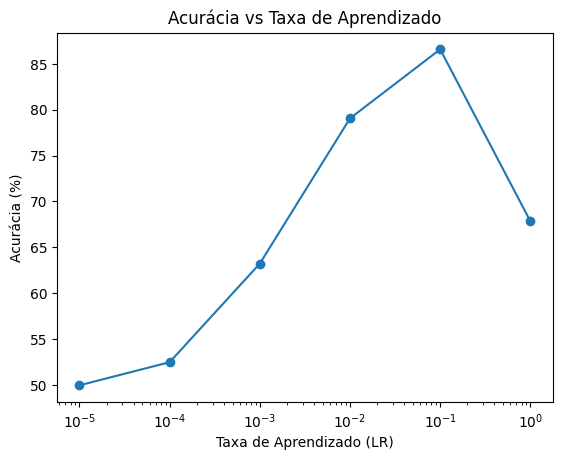

O melhor LR é 0.1 com acurácia de 86.568%


In [ ]:
import matplotlib.pyplot as plt

# Valores de LR para testar
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
accuracies = []

# Função para treinar e avaliar o modelo
def train_and_evaluate(lr):
    model = OneHotMLP(vocab_size)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(5):  # 5 épocas
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            loss = criterion(logits.squeeze(), targets.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Avaliação
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            predicted = torch.round(torch.sigmoid(logits.squeeze()))
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Teste cada valor de LR
for lr in learning_rates:
    acc = train_and_evaluate(lr)
    accuracies.append(acc)
    print(f'LR: {lr}, Acurácia: {acc}%')

# Plotar resultados
plt.plot(learning_rates, accuracies, marker='o')
plt.xscale('log')  # Usar escala logarítmica para LR
plt.xlabel('Taxa de Aprendizado (LR)')
plt.ylabel('Acurácia (%)')
plt.title('Acurácia vs Taxa de Aprendizado')
plt.show()

# Escolher o melhor LR
best_lr = learning_rates[accuracies.index(max(accuracies))]
print(f'O melhor LR é {best_lr} com acurácia de {max(accuracies)}%')

# Exercício VII.3

In [ ]:
print(encode_sentence("Hello, world! This is a test sentence with punctuation and CAPITALS.", vocab))
print(encode_sentence("Hello world This is a test sentence with punctuation and capitals", vocab))

[0, 0, 48, 6, 2, 2662, 7229, 15, 0, 3, 0]
[13918, 281, 48, 6, 2, 2662, 7229, 15, 0, 3, 0]


In [ ]:
import string
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()
    # Remover pontuações
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

train_dataset = load_dataset("stanfordnlp/imdb", split="train")

def encode_sentence(sentence, vocab):
    sentence = preprocess_text(sentence) # Modificação
    return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV

encode_sentence("I like Pizza.", vocab)

vocab_size = 20000

counter = Counter()
for sample in train_dataset: #
    preprocessed_text = preprocess_text(sample["text"])  # Pré-processar o texto
    counter.update(preprocessed_text.split())  # Atualizar o contador com tokens

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}
vocab_size = len(vocab)

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):
        self.data = load_dataset("stanfordnlp/imdb", split=split)
        self.vocab = vocab
        # Pré-processar os dados para one-hot encoding
        self.encoded_data = []
        for sample in self.data:
            target = sample["label"]
            line = sample["text"]
            target = 1 if target == 1 else 0
            # one-hot encoding
            X = torch.zeros(len(self.vocab) + 1)
            for word in encode_sentence(line, self.vocab):
                X[word] = 1
            self.encoded_data.append((X, torch.tensor(target)))

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        return self.encoded_data[idx]

In [ ]:
num_unknown_tokens = 0
for sample in train_dataset:
    encoded_sentence = encode_sentence(preprocess_text(sample["text"]), vocab)
    num_unknown_tokens += encoded_sentence.count(0)

print(f"Número de tokens desconhecidos no conjunto de treinamento: {num_unknown_tokens}")

Número de tokens desconhecidos no conjunto de treinamento: 214473


In [ ]:
model = OneHotMLP(vocab_size)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
for epoch in range(5):  # 5 épocas
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        loss = criterion(logits.squeeze(), targets.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Avaliação
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        predicted = torch.round(torch.sigmoid(logits.squeeze()))
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f"Acurácia nova: {accuracy}%")

Acurácia nova: 87.4%
